In [1]:
import itertools

import datacube
import dea_tools.datahandling
import dea_tools.bandindices
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd

# runtime is: https://app.sandbox.dea.ga.gov.au/

dc = datacube.Datacube(app='Burn Cube S2 C3 notebook')

In [2]:
# download from: https://raw.githubusercontent.com/GeoscienceAustralia/burn-mapping/develop/dea_burn_cube/utils.py
import utils as utils

In [3]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import rioxarray
import json
from PIL import Image
import xarray as xr
from dea_tools.spatial import xr_rasterize

In [4]:
import pyproj

# provide center coordinates (longitude and latitude) 
# example relates to the Sir Ivan fire in 2017 around Uarbry in NSW
# This area comes from: https://github.com/GeoscienceAustralia/burn-mapping/blob/c1c139da69930c9c7ac9ebdc1a21bc773500d716/BurnCube/Burn_Mapping_BurnCube_example.ipynb
lon =  149.6593 
lat = -32.0649

# convert to projected centre coordinates
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3577")
easting,northing = transformer.transform(lat, lon)

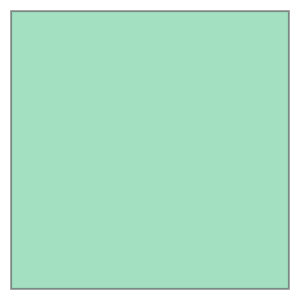

In [5]:
buffer = 12500

p1 = (easting+buffer, northing+buffer)
p2 = (easting-buffer, northing+buffer)
p3 = (easting-buffer, northing-buffer)
p4 = (easting+buffer, northing-buffer)

import geopandas as gpd
from shapely.geometry import Polygon
polygon_geom = Polygon((p1, p2, p3, p4))
crs = 'EPSG:3577'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       
polygon.iloc[0].geometry

In [6]:
def stretch_RGB(data):
    """
    stretch RGB to 0-1
    """
    import numpy as np
    tmp = data
    a = (tmp-np.nanpercentile(tmp,1))/(np.nanpercentile(tmp,99.5)-np.nanpercentile(tmp,0.5))*255 
    a[a>255]=255
    a[a<0]=0
    return a

def RGB_plot(R, G, B):
    import numpy as np
    from PIL import Image   
    rgbArray = np.zeros((R.shape[0],R.shape[1],3), 'uint8')
    rgbArray[..., 0] = (stretch_RGB(R))
    rgbArray[..., 1] = (stretch_RGB(G))
    rgbArray[..., 2] = (stretch_RGB(B))
    img = Image.fromarray(np.flipud(rgbArray))
    return img.resize((500,500))

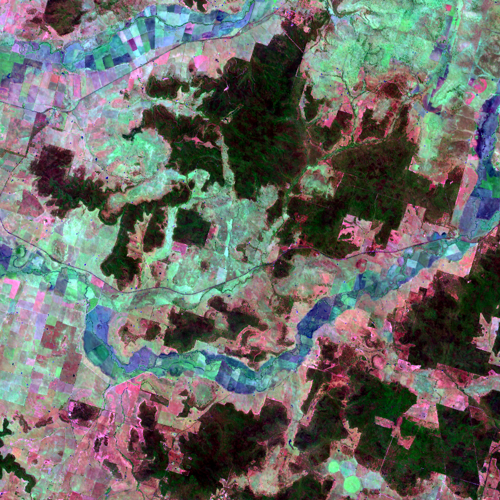

In [7]:
from PIL import Image
import xarray as xr
import rioxarray
from dea_tools.spatial import xr_rasterize

x_code = "x45"
y_code = "y19"
region_code = f"{x_code}{y_code}"

swir2 = rioxarray.open_rasterio(f"burn_cube_s2_geomad_test/{x_code}/{y_code}/2015--P3Y/ga_s2am_ard_gm_4cyear_3_{region_code}_2015--P3Y_final_nbart_swir_2.tif")
nir = rioxarray.open_rasterio(f"burn_cube_s2_geomad_test/{x_code}/{y_code}/2015--P3Y/ga_s2am_ard_gm_4cyear_3_{region_code}_2015--P3Y_final_nbart_nir_2.tif")
green = rioxarray.open_rasterio(f"burn_cube_s2_geomad_test/{x_code}/{y_code}/2015--P3Y/ga_s2am_ard_gm_4cyear_3_{region_code}_2015--P3Y_final_nbart_green.tif")
    
mask = xr_rasterize(polygon.iloc[[0]], swir2)

image = RGB_plot(swir2.where(mask, drop=True)[0].data,
                nir.where(mask, drop=True)[0].data,
                green.where(mask, drop=True)[0].data,
                )
        
display(image.transpose(Image.FLIP_TOP_BOTTOM))

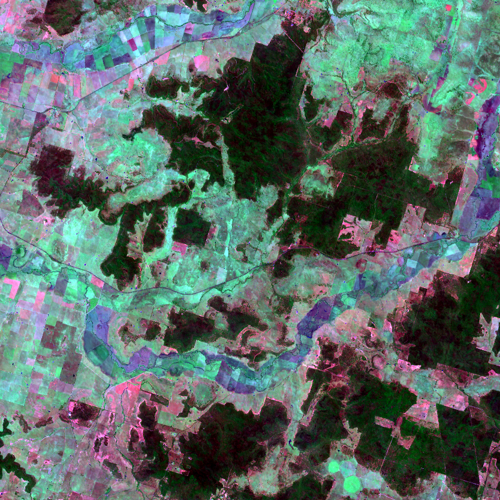

In [8]:
swir3 = rioxarray.open_rasterio(f"burn_cube_s2_geomad_test/{x_code}/{y_code}/2015--P3Y/ga_s2am_ard_gm_4cyear_3_{region_code}_2015--P3Y_final_nbart_swir_3.tif")
    
mask = xr_rasterize(polygon.iloc[[0]], swir3)

image = RGB_plot(swir3.where(mask, drop=True)[0].data,
                nir.where(mask, drop=True)[0].data,
                green.where(mask, drop=True)[0].data,
                )
        
display(image.transpose(Image.FLIP_TOP_BOTTOM))

In [9]:
import itertools

import datacube
import dea_tools.datahandling
import dea_tools.bandindices
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd

dc = datacube.Datacube(app='Burn Cube S2 C3 notebook')

bands = [f'nbart_{band}' for band in ('blue', 'green', 'red', 'nir_2', 'swir_2', 'swir_3')]

period = ('2013-01-01','2016-12-31')

gpgon = datacube.utils.geometry.Geometry(polygon.geometry[0], crs=polygon.crs)

ard = dea_tools.datahandling.load_ard(dc, products=['ga_s2am_ard_3'], measurements=bands,
                                     geopolygon=gpgon,
                                     output_crs='EPSG:3577', resolution=(-30, 30), cloud_mask='s2cloudless',
                                     time=period, group_by='solar_day')

Finding datasets
    ga_s2am_ard_3
Applying s2cloudless pixel quality/cloud mask
Loading 34 time steps


CPLReleaseMutex: Error = 1 (Operation not permitted)


In [10]:
ard

<xarray.Dataset>
Dimensions:       (time: 34, y: 834, x: 834)
Coordinates:
  * time          (time) datetime64[ns] 2015-10-23T00:02:46.460000 ... 2016-1...
  * y             (y) float64 -3.596e+06 -3.596e+06 ... -3.621e+06 -3.621e+06
  * x             (x) float64 1.635e+06 1.635e+06 ... 1.66e+06 1.66e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_red     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_nir_2   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_swir_2  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_swir_3  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [11]:
geomad_dataset = []

for band_name in bands:
    band_data = rioxarray.open_rasterio(f"burn_cube_s2_geomad_test/{x_code}/{y_code}/2015--P3Y/ga_s2am_ard_gm_4cyear_3_{region_code}_2015--P3Y_final_{band_name}.tif")

    mask = xr_rasterize(polygon.iloc[[0]], band_data)
    
    geomad_dataset.append(band_data.where(mask, drop=True)[0, :, :].to_dataset(name=band_name))

geomad_ds = xr.merge(geomad_dataset)

geomed = geomad_ds[bands].to_array(dim='band').to_dataset(name='geomedian')
geomed.attrs["crs"] = ard.crs
geomed

<xarray.Dataset>
Dimensions:    (band: 6, x: 834, y: 833)
Coordinates:
  * band       (band) <U12 'nbart_blue' 'nbart_green' ... 'nbart_swir_3'
  * x          (x) float64 1.635e+06 1.635e+06 1.635e+06 ... 1.66e+06 1.66e+06
  * y          (y) float64 -3.596e+06 -3.596e+06 ... -3.621e+06 -3.621e+06
Data variables:
    geomedian  (band, y, x) float64 941.0 937.0 781.0 ... 1.684e+03 1.145e+03
Attributes:
    crs:      EPSG:3577

In [12]:
# ARD and GeoMED data size are different, have to merge them
overall_data = xr.combine_by_coords([ard, geomed], coords=["x", "y"], join="inner", combine_attrs='override')
overall_data

<xarray.Dataset>
Dimensions:       (y: 833, band: 6, x: 834, time: 34)
Coordinates:
  * y             (y) float64 -3.596e+06 -3.596e+06 ... -3.621e+06 -3.621e+06
  * band          (band) <U12 'nbart_blue' 'nbart_green' ... 'nbart_swir_3'
  * x             (x) float64 1.635e+06 1.635e+06 ... 1.66e+06 1.66e+06
  * time          (time) datetime64[ns] 2015-10-23T00:02:46.460000 ... 2016-1...
    spatial_ref   int32 3577
Data variables:
    geomedian     (band, y, x) float64 941.0 937.0 781.0 ... 1.684e+03 1.145e+03
    nbart_blue    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_red     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_nir_2   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_swir_2  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_swir_3  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:      EPSG:3577

In [13]:
dataset = overall_data[bands].to_array(dim='band').to_dataset(name='cube')

In [14]:
ard = dataset['cube']
geomed = overall_data["geomedian"]

In [15]:
dis = utils.distances(ard, geomed)

/home/jovyan/burn_cube/utils.py:468: RuntimeWarning: invalid value encountered in true_divide
  nbr = (ard[3, :, i] - ard[5, :, i]) / (ard[3, :, i] + ard[5, :, i])
/home/jovyan/burn_cube/utils.py:468: RuntimeWarning: invalid value encountered in true_divide
  nbr = (ard[3, :, i] - ard[5, :, i]) / (ard[3, :, i] + ard[5, :, i])
/home/jovyan/burn_cube/utils.py:468: RuntimeWarning: invalid value encountered in true_divide
  nbr = (ard[3, :, i] - ard[5, :, i]) / (ard[3, :, i] + ard[5, :, i])
/home/jovyan/burn_cube/utils.py:468: RuntimeWarning: invalid value encountered in true_divide
  nbr = (ard[3, :, i] - ard[5, :, i]) / (ard[3, :, i] + ard[5, :, i])
/home/jovyan/burn_cube/utils.py:468: RuntimeWarning: invalid value encountered in true_divide
  nbr = (ard[3, :, i] - ard[5, :, i]) / (ard[3, :, i] + ard[5, :, i])
/home/jovyan/burn_cube/utils.py:468: RuntimeWarning: invalid value encountered in true_divide
  nbr = (ard[3, :, i] - ard[5, :, i]) / (ard[3, :, i] + ard[5, :, i])
/home/jovyan/bur

In [16]:
dis

<xarray.Dataset>
Dimensions:      (time: 34, y: 833, x: 834, band: 6)
Coordinates:
  * time         (time) datetime64[ns] 2015-10-23T00:02:46.460000 ... 2016-12...
    spatial_ref  int32 3577
  * y            (y) float64 -3.596e+06 -3.596e+06 ... -3.621e+06 -3.621e+06
  * x            (x) float64 1.635e+06 1.635e+06 1.635e+06 ... 1.66e+06 1.66e+06
  * band         (band) <U12 'nbart_blue' 'nbart_green' ... 'nbart_swir_3'
Data variables:
    CDist        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    NBRDist      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    ChangeDir    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NBR          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:      EPSG:3577

In [17]:
outliers_result = utils.outliers(ard, dis)

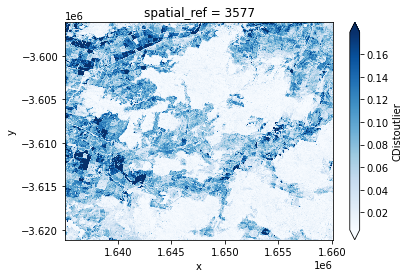

In [18]:
outliers_result.CDistoutlier.plot.imshow(robust=True,cmap='Blues')

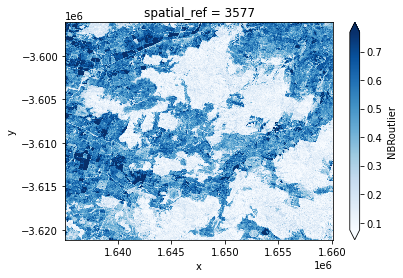

In [19]:
outliers_result.NBRoutlier.plot.imshow(robust=True,cmap='Blues')

In [20]:
mappingperiod = ('2017-01-01','2017-12-31')

mapping_ard = dea_tools.datahandling.load_ard(dc, products=['ga_s2am_ard_3'], measurements=bands,
                                     geopolygon=gpgon,
                                     output_crs='EPSG:3577', resolution=(-30, 30), cloud_mask='s2cloudless',
                                     time=mappingperiod, group_by='solar_day')

Finding datasets
    ga_s2am_ard_3
Applying s2cloudless pixel quality/cloud mask
Loading 37 time steps


In [21]:
overall_data = xr.combine_by_coords([mapping_ard, geomed], coords=["x", "y"], join="inner", combine_attrs='override')
overall_data

<xarray.Dataset>
Dimensions:       (y: 833, band: 6, x: 834, time: 37)
Coordinates:
  * y             (y) float64 -3.596e+06 -3.596e+06 ... -3.621e+06 -3.621e+06
  * band          (band) <U12 'nbart_blue' 'nbart_green' ... 'nbart_swir_3'
  * x             (x) float64 1.635e+06 1.635e+06 ... 1.66e+06 1.66e+06
    spatial_ref   int32 3577
  * time          (time) datetime64[ns] 2017-01-05T00:02:44.539000 ... 2017-1...
Data variables:
    geomedian     (band, y, x) float64 941.0 937.0 781.0 ... 1.684e+03 1.145e+03
    nbart_blue    (time, y, x) float32 1.058e+03 1.014e+03 1.019e+03 ... nan nan
    nbart_green   (time, y, x) float32 1.365e+03 1.344e+03 1.326e+03 ... nan nan
    nbart_red     (time, y, x) float32 1.959e+03 1.894e+03 1.901e+03 ... nan nan
    nbart_nir_2   (time, y, x) float32 3.193e+03 3.216e+03 2.86e+03 ... nan nan
    nbart_swir_2  (time, y, x) float32 4.304e+03 4.313e+03 4.275e+03 ... nan nan
    nbart_swir_3  (time, y, x) float32 2.944e+03 2.924e+03 3.121e+03 ... nan nan

In [22]:
mapping_dataset = overall_data[bands].to_array(dim='band').to_dataset(name='cube')

In [23]:
mapping_ard = mapping_dataset['cube']

In [24]:
mapping_dis = utils.distances(mapping_ard, geomed)

/home/jovyan/burn_cube/utils.py:468: RuntimeWarning: invalid value encountered in true_divide
  nbr = (ard[3, :, i] - ard[5, :, i]) / (ard[3, :, i] + ard[5, :, i])
/home/jovyan/burn_cube/utils.py:468: RuntimeWarning: invalid value encountered in true_divide
  nbr = (ard[3, :, i] - ard[5, :, i]) / (ard[3, :, i] + ard[5, :, i])
/home/jovyan/burn_cube/utils.py:468: RuntimeWarning: invalid value encountered in true_divide
  nbr = (ard[3, :, i] - ard[5, :, i]) / (ard[3, :, i] + ard[5, :, i])
/home/jovyan/burn_cube/utils.py:468: RuntimeWarning: invalid value encountered in true_divide
  nbr = (ard[3, :, i] - ard[5, :, i]) / (ard[3, :, i] + ard[5, :, i])
/home/jovyan/burn_cube/utils.py:468: RuntimeWarning: invalid value encountered in true_divide
  nbr = (ard[3, :, i] - ard[5, :, i]) / (ard[3, :, i] + ard[5, :, i])
/home/jovyan/burn_cube/utils.py:468: RuntimeWarning: invalid value encountered in true_divide
  nbr = (ard[3, :, i] - ard[5, :, i]) / (ard[3, :, i] + ard[5, :, i])
/home/jovyan/bur

In [25]:
# download from: https://ga-sentinel.s3-ap-southeast-2.amazonaws.com/historic/all-data-csv.zip
hotspotfile = "hotspot_historic.csv"

In [26]:
out = utils.severitymapping(
        mapping_dis,
        outliers_result,
        mappingperiod,
        hotspotfile,
        method="NBR",
        growing=True,
    )

/env/lib/python3.8/site-packages/matplotlib/path.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = _to_unmasked_float_array(vertices)


In [27]:
# save the output in netCDF
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in out.data_vars}
out.to_netcdf('BurnMapping_SirIvan_2017_S2_C3_AWS_sandbox.nc',encoding=encoding)

# save the output in GeoTIFF
from datacube.utils.cog import write_cog

for data_var_name in out.data_vars:
    write_cog(out[data_var_name], fname=data_var_name + ".tif", overwrite=True)
    df = out[data_var_name].to_dataframe().reset_index()
    #gdf = gpd.GeoDataFrame(df.value_column, geometry=gpd.points_from_xy(df.lon,df.lat))
    #print(gdf.iloc[0].geometry)

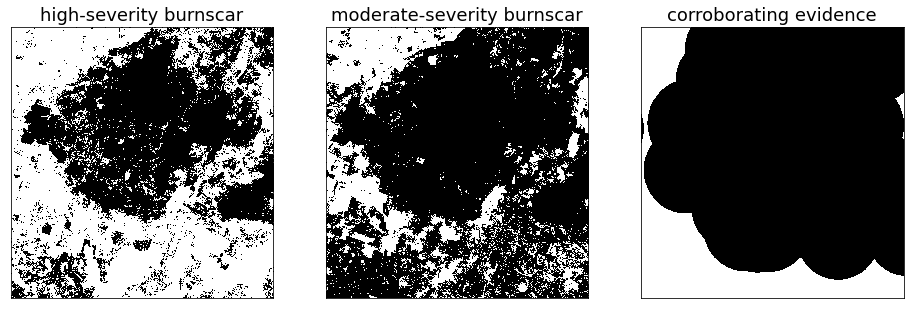

In [28]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(ncols=3,figsize=[16,5])
#plot the high-severity burns 
cax1=out.Severe.plot.imshow(ax=axes[0],cmap='binary',add_colorbar=False)
cax1.axes.set_title('high-severity burnscar',fontsize=18)
cax1.axes.get_xaxis().set_visible(False)
cax1.axes.get_yaxis().set_visible(False)
#plot the moderate severity burns
cax2=out.Moderate.plot.imshow(ax=axes[1],cmap='binary',add_colorbar=False)
cax2.axes.set_title('moderate-severity burnscar',fontsize=18)
cax2.axes.get_xaxis().set_visible(False)
cax2.axes.get_yaxis().set_visible(False)
#plot corroborating evidence from hotspots data
cax3=out.Corroborate.plot.imshow(ax=axes[2],cmap='binary',add_colorbar=False)
cax3.axes.set_title('corroborating evidence',fontsize=18)
cax3.axes.get_xaxis().set_visible(False)
cax3.axes.get_yaxis().set_visible(False)

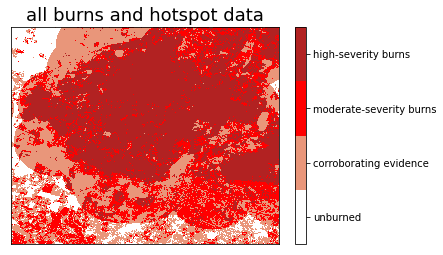

In [29]:
#plot both high and moderate burns with the hotspot data
Allburnt = out.Severe+out.Moderate+out.Corroborate
from matplotlib.colors import ListedColormap
fig,axes=plt.subplots()
cMap = ListedColormap(['white','darksalmon','red','firebrick'])
cax=Allburnt.plot.imshow(cmap=cMap,levels=[0,1,2,3,4],add_colorbar=False)
cax.axes.set_title('all burns and hotspot data',fontsize=18)
cbar = fig.colorbar(cax,ticks=[0.5,1.5,2.5,3.5])
cbar.ax.set_yticklabels(['unburned','corroborating evidence','moderate-severity burns','high-severity burns'])
cax.axes.get_xaxis().set_visible(False)
cax.axes.get_yaxis().set_visible(False)

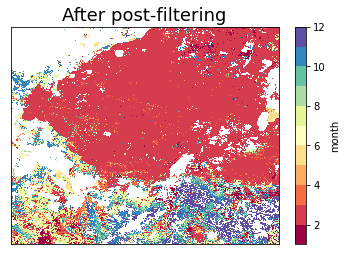

In [30]:
import numpy as np
plt.figure()
cMap = plt.get_cmap('Spectral',11)
cMap.set_under('white')
Cleaned = out.Cleaned.copy()
Cleaned.data = np.ma.masked_where(out.Cleaned.data==0,out.Cleaned.data) # masked out unburnt area with 0 values
cax=Cleaned.plot.imshow(cmap=cMap,add_colorbar=False,vmax=12)
plt.colorbar(cax,pad=0.05,label='month') # the cleaned layer contains the information of burnt month in the calendar year
cax.axes.set_title('After post-filtering',fontsize=18)
cax.axes.get_xaxis().set_visible(False)
cax.axes.get_yaxis().set_visible(False)